<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rownames      2571 non-null   int64 
 1   Person_ID     2571 non-null   int64 
 2   Hospitalised  2571 non-null   object
 3   Died          2571 non-null   object
 4   Urban         2571 non-null   object
 5   Year          2571 non-null   int64 
 6   Month         2571 non-null   int64 
 7   Sex           2571 non-null   object
 8   Age           2571 non-null   int64 
 9   Education     2571 non-null   object
 10  Occupation    2571 non-null   object
 11  method        2571 non-null   object
dtypes: int64(5), object(7)
memory usage: 241.2+ KB
None
   rownames  Person_ID Hospitalised Died Urban  Year  Month     Sex  Age  \
0         1          1          yes   no    no  2010     12  female   39   
1         2          2           no  yes    no  2009      3    male   83   
2         3         

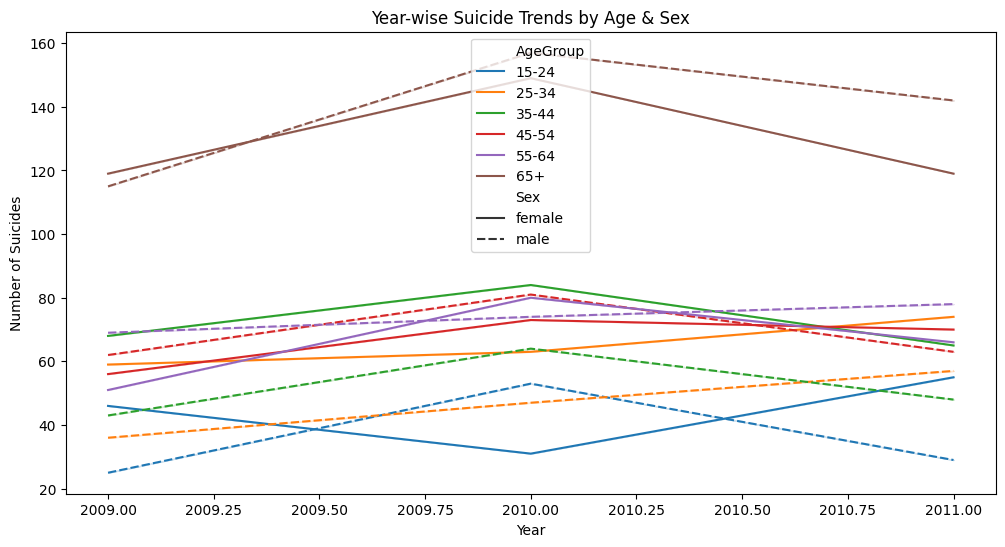

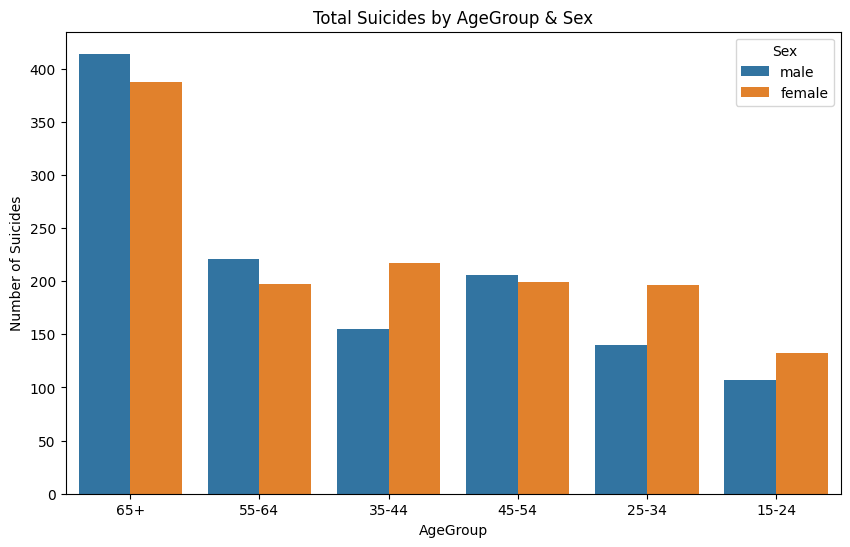

/tmp/ipython-input-3192959293.py:66: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_heat = data.pivot_table(index='AgeGroup', columns='Year', values='Age', aggfunc='count')


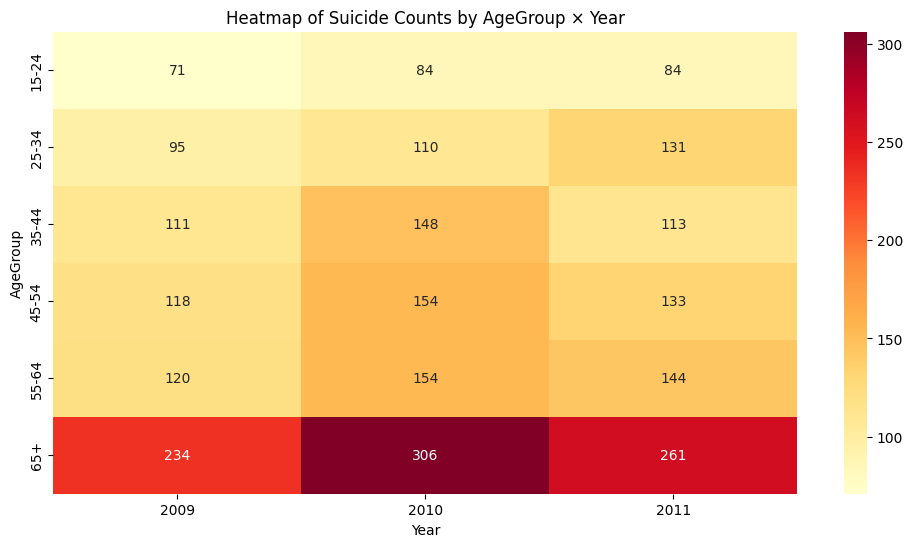

/tmp/ipython-input-3192959293.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = data.pivot_table(index=['AgeGroup','Sex'], columns='Year', values='Age', aggfunc='count').fillna(0)


Clusters Assigned:
 AgeGroup  Sex   
15-24     female    2
          male      2
25-34     female    0
          male      2
35-44     female    0
          male      2
45-54     female    0
          male      0
55-64     female    0
          male      0
65+       female    1
          male      1
Name: Cluster, dtype: int32


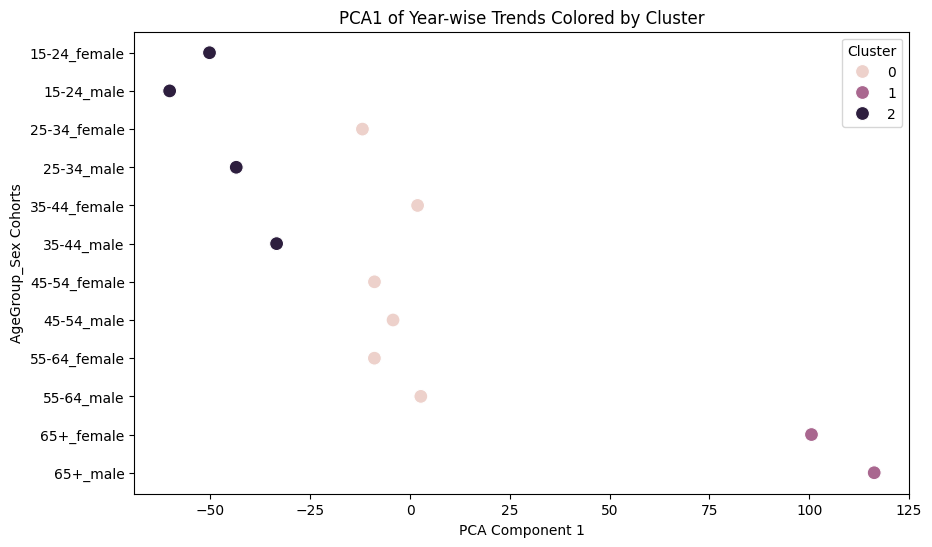


Cluster 2:
Year             2009  2010  2011  Cluster       PCA1
AgeGroup Sex                                         
15-24    female    46    31    55        2 -50.243745
         male      25    53    29        2 -60.229712
25-34    male      36    47    57        2 -43.547933
35-44    male      43    64    48        2 -33.432132

Cluster 0:
Year             2009  2010  2011  Cluster       PCA1
AgeGroup Sex                                         
25-34    female    59    63    74        0 -11.925190
35-44    female    68    84    65        0   1.892057
45-54    female    56    73    70        0  -8.910415
         male      62    81    63        0  -4.258661
55-64    female    51    80    66        0  -8.926938
         male      69    74    78        0   2.706132

Cluster 1:
Year             2009  2010  2011  Cluster        PCA1
AgeGroup Sex                                          
65+      female   119   149   119        1  100.581685
         male     115   157   142        1 

In [1]:

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 2️⃣ Load Dataset
url = "https://raw.githubusercontent.com/salemprakash/EDA/main/Data/SuicideChina.csv"
data = pd.read_csv(url)

# 3️⃣ Inspect Dataset
print(data.info())
print(data.head())
print(data.describe())

# 4️⃣ Data Cleaning & Preprocessing
# Create AgeGroup from Age
bins = [0, 24, 34, 44, 54, 64, 100]  # age ranges
labels = ["15-24", "25-34", "35-44", "45-54", "55-64", "65+"]  # group labels
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=True)

# Make AgeGroup categorical and ordered
data['AgeGroup'] = pd.Categorical(data['AgeGroup'], ordered=True, categories=labels)

# Convert other categorical columns
categorical_cols = ['Sex', 'Hospitalised', 'Died', 'Urban', 'Education', 'Occupation', 'method']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Drop rows with missing AgeGroup (if any)
data.dropna(subset=['AgeGroup'], inplace=True)

# 5️⃣ Prepare Data for SQL in Google Colab
conn = sqlite3.connect("suicide_china.db")
data.to_sql("suicides", conn, if_exists='replace', index=False)

# Example SQL query: Total suicides by AgeGroup & Sex
query = """
SELECT AgeGroup, Sex, COUNT(*) as total_suicides
FROM suicides
GROUP BY AgeGroup, Sex
ORDER BY total_suicides DESC;
"""
avg_suicides = pd.read_sql_query(query, conn)
print(avg_suicides)

# 6️⃣ Exploratory Data Analysis (EDA)
# Line plot: Year-wise suicide trends by AgeGroup & Sex
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Year', y='Age', hue='AgeGroup', style='Sex', estimator=len)
plt.title("Year-wise Suicide Trends by Age & Sex")
plt.xlabel("Year")
plt.ylabel("Number of Suicides")
plt.show()

# Bar plot: Total suicides by AgeGroup & Sex
plt.figure(figsize=(10,6))
sns.barplot(data=avg_suicides, x='AgeGroup', y='total_suicides', hue='Sex')
plt.title("Total Suicides by AgeGroup & Sex")
plt.ylabel("Number of Suicides")
plt.show()

# Heatmap: AgeGroup × Year suicide trends (aggregate counts)
pivot_heat = data.pivot_table(index='AgeGroup', columns='Year', values='Age', aggfunc='count')
plt.figure(figsize=(12,6))
sns.heatmap(pivot_heat, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Heatmap of Suicide Counts by AgeGroup × Year")
plt.show()

# 7️⃣ Clustering: K-Means on Year-wise Trends
# Pivot: AgeGroup × Sex as rows, Years as columns
pivot = data.pivot_table(index=['AgeGroup','Sex'], columns='Year', values='Age', aggfunc='count').fillna(0)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
pivot['Cluster'] = kmeans.fit_predict(pivot)

print("Clusters Assigned:\n", pivot['Cluster'])

# 8️⃣ Dimensionality Reduction: PCA
pca = PCA(n_components=1)
pivot['PCA1'] = pca.fit_transform(pivot.drop('Cluster', axis=1))

# Scatter plot of PCA1 vs Cohorts colored by Cluster
plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y=pivot.index.map(lambda x: f"{x[0]}_{x[1]}"),
                hue='Cluster', data=pivot.reset_index(), s=100)
plt.title("PCA1 of Year-wise Trends Colored by Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("AgeGroup_Sex Cohorts")
plt.show()

# 9️⃣ Insights Summary: High-risk groups by cluster
for i in pivot['Cluster'].unique():
    print(f"\nCluster {i}:")
    print(pivot[pivot['Cluster']==i])

# Close SQL connection
conn.close()
